# Imputation of air-freight transportation

I have to determine which items are transported by air-freight because this has a large impact on carbon emissions.

To impute AIR I will make the following assumptions:
- FRESH fruits, vegetables, seafood, dairy products, transported ACROSS CONTINENTS
- FRESH fruits, vegetables, seafood, dairy products, transported MORE THAN xxx KM
- All items listed below

To calculate CO2 emissions I will:

- Use values in table below. For land transport I will use 25% of emissions as rail transport and 75% of emissions as road transport.
- Use the column "conservation" in items data to impute either "ambient transport" or "temp-controlled" CO2 emissions.


# Sources:

Smith A and others, “The Validity of Food Miles as an Indicator of Sustainable Development Final Report Produced for DEFRA” (2005)
https://webarchive.nationalarchives.gov.uk/ukgwa/20130125041710/http://www.defra.gov.uk/statistics/files/defra-stats-foodfarm-food-transport-foodmiles-050715.pdf

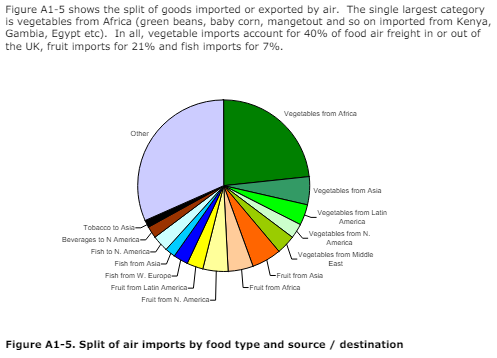

https://ourworldindata.org/food-transport-by-mode

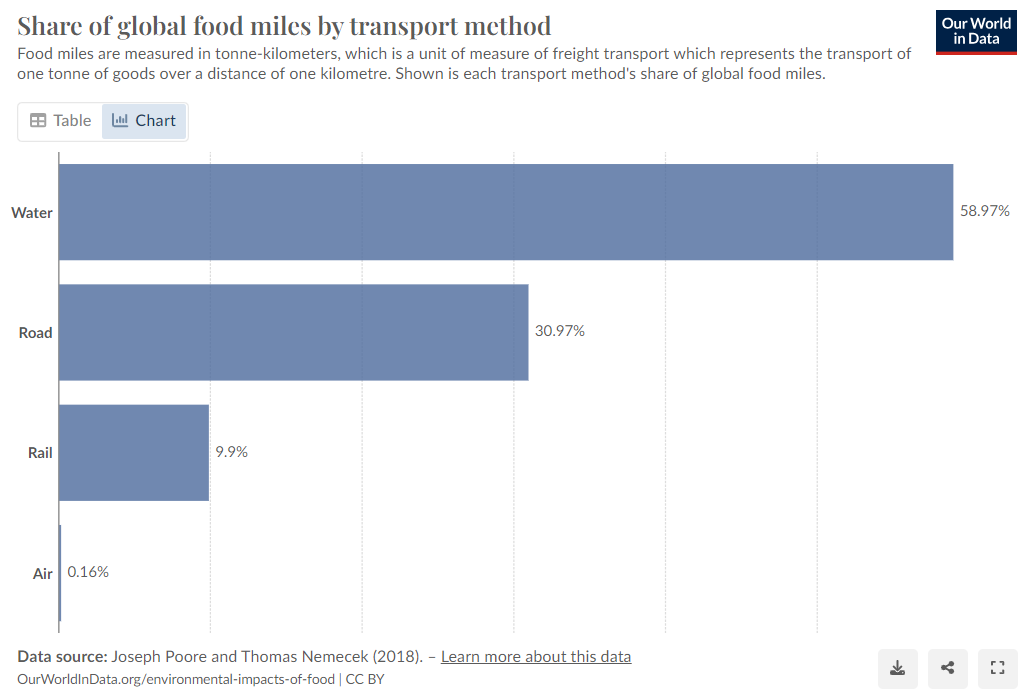

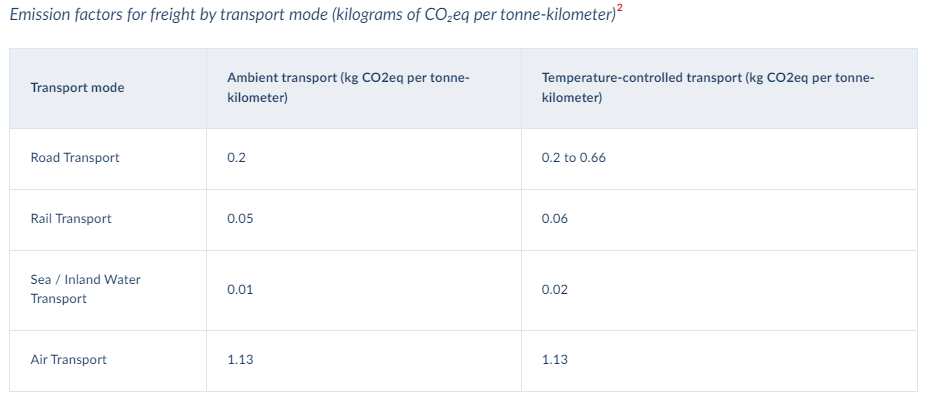

## List of commonly air-freight food products:

Fruits: mangoes, avocados, berries, grapes, citrus fruits, bananas, pineapples

Vegetables: asparagus, green beans, broccoli, cauliflower, carrots, lettuce, peppers

Seafood: shrimp, lobster, crab, salmon, tuna

Meat: beef, pork, lamb, poultry

Dairy products: cheese, yogurt, butter

# From report in International Transport Forum

https://www.itf-oecd.org/sites/default/files/docs/cop-pdf-06.pdf

The underlying trade projections
up to 2050 assume that GDP will grow on average
around 3% per year with declining rates in many
countries. Growth in trade is expected to continue to
outpace GDP growth with world trade estimated to
grow at around 3.5% annually, compared to 6.9%
over the period 1990-2007. 

Still, global trade is projected to grow by a factor
of 4.1 from 2010 to 2050 (in constant value). The
weight of trade (in tonnes of goods moved) will grow
less, by a factor of 3.8, reflecting changes in the
product composition of the world trade and more
specifically the fact that countries are moving up in
the value chain, producing more high value goods

Road freight share of total
international trade-related emissions will grow from
53% in 2010 to 56% by 2050. 

Over the same period,
air transport will see an increase of 2 percentage
points from 7% to 9%, according to ITF projections. 

# Air-freight imputation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#save and load as parquet (for big files)
import pyarrow as pa
import pyarrow.parquet as pq

In [2]:
full_trade_mx = pd.read_parquet(r"..\data\FAOSTAT\clean_data\food_trading\trade_matrix__imports_clean_distance_v3.parquet")

In [3]:
#full_trade_mx = full_trade_mx.sample(2000000)

In [4]:
full_trade_mx['transportation_method'].value_counts(normalize=True, dropna=False)

transportation_method
water    0.598939
land     0.401061
Name: proportion, dtype: float64

In [5]:
items = pd.read_csv(r"..\data\FAOSTAT\clean_data\food_codes_categorized_final.csv", encoding="ISO-8859-1")

In [6]:
items['conservation'].value_counts(normalize=True, dropna=False)

conservation
Ambient    0.773124
Fresh      0.120419
Chilled    0.106457
Name: proportion, dtype: float64

In [7]:
full_trade_mx = full_trade_mx[full_trade_mx['distance_in_km'] > 0] #filter remaining null distances (only 0.01%)

## Observe mean distance travel of goods by conservation

In [8]:
full_trade_mx = full_trade_mx.merge(items[['Item_Code', 'conservation', 'food_type']], how='left', left_on='Item Code', right_on='Item_Code')

In [9]:
full_trade_mx.head()

,Reporter Country Code,Partner Country Code,Item Code,Year,Value_tons,Flag,distance_in_km,same_continent,share_border,any_island_or_missing,transportation_method,Item_Code,conservation,food_type
0,4,2,231,2005,3.00,A,5855.362822,0,0.0,0,water,231,Ambient,nuts
1,3,3,56,2005,52.00,A,108.698297,1,1.0,0,land,56,Ambient,grain
2,7,2,176,2022,25.06,A,7596.963990,0,0.0,0,water,176,Ambient,legume
3,4,2,711,1996,171.00,A,5855.362822,0,0.0,0,water,711,Ambient,other
4,4,2,711,1997,160.00,A,5855.362822,0,0.0,0,water,711,Ambient,other


In [10]:
data = full_trade_mx[full_trade_mx['transportation_method'] == 'water'].sample(100000)

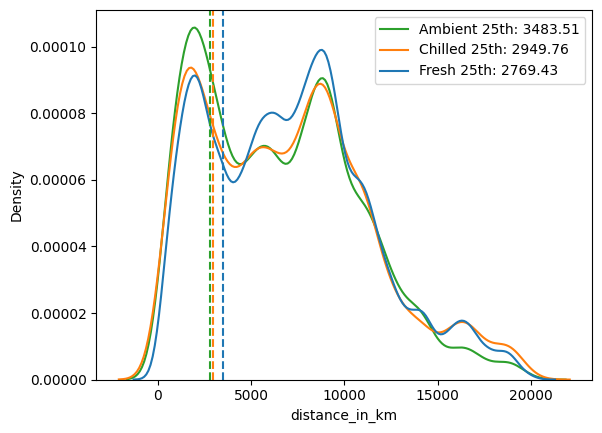

In [11]:
# Calculate the 75th percentile for each category
percentiles = data.groupby('conservation')['distance_in_km'].quantile(0.25)

# Create the KDE plot
ax = sns.kdeplot(
    data=data,
    x='distance_in_km',
    hue='conservation',
    #stat="density",
    common_norm=False # Normalizes each category independently
)

# Get the current color palette
palette = sns.color_palette()

# Add vertical lines for the 75th percentiles and annotate
for (conservation, percentile), color in zip(percentiles.items(), palette):
    plt.axvline(percentile, linestyle='--', color=color)

# Remove the default legend
ax.legend_.remove()

# Adding custom legend
legend_labels = [f'{conservation} 25th: {percentile:.2f}' for conservation, percentile in percentiles.items()]
ax.legend(legend_labels, loc='upper right')

# Show the plot
plt.show()

# Asumptions:

## Finally I used a custom list of items found in several sources

To impute AIR I will make the following assumptions:
- FRESH fruits, vegetables, seafood, dairy products, transported to a different continent
- FRESH fruits, vegetables, seafood, dairy products, transported MORE THAN 5000 KM

## using distances and other assumptions food type assumptions

In [12]:
#full_trade_mx1 = full_trade_mx.copy()

In [13]:
# Add food miles column
#full_trade_mx1['food_miles'] = (full_trade_mx1['Value_tons'] * full_trade_mx1['distance_in_km'])

In [14]:
"""condition1 = (                                                              #depends on DIFFERENT CONTINENT
    (full_trade_mx1['same_continent'] == 0) &
    (full_trade_mx1['conservation'].isin(['Fresh', 'Chilled'])) &
    (full_trade_mx1['food_type'].isin(['fruit/vegetable', 'dairy/eggs', 'dairy']))
)

condition2 = (                                                              #depends on DISTANCE
    (full_trade_mx1['distance_in_km'] > 5000) &
    (full_trade_mx1['conservation'].isin(['Fresh', 'Chilled'])) &
    (full_trade_mx1['food_type'].isin(['fruit/vegetable', 'dairy/eggs', 'dairy']))
)

full_trade_mx1['air'] = np.where(condition1 | condition2, 1, 0)"""

"condition1 = (                                                              #depends on DIFFERENT CONTINENT\n    (full_trade_mx1['same_continent'] == 0) &\n    (full_trade_mx1['conservation'].isin(['Fresh', 'Chilled'])) &\n    (full_trade_mx1['food_type'].isin(['fruit/vegetable', 'dairy/eggs', 'dairy']))\n)\n\ncondition2 = (                                                              #depends on DISTANCE\n    (full_trade_mx1['distance_in_km'] > 5000) &\n    (full_trade_mx1['conservation'].isin(['Fresh', 'Chilled'])) &\n    (full_trade_mx1['food_type'].isin(['fruit/vegetable', 'dairy/eggs', 'dairy']))\n)\n\nfull_trade_mx1['air'] = np.where(condition1 | condition2, 1, 0)"

In [15]:
#full_trade_mx1['transportation_method'] = np.where(full_trade_mx1['air'] == 1, 'air', full_trade_mx1['transportation_method'])

In [16]:
# Group the DataFrame by 'transportation_method' and sum the 'food_miles' for each method
"""transportation_method_sum = full_trade_mx1.groupby('transportation_method')['food_miles'].sum()

# Calculate the total sum of 'food_miles'
total_food_miles = transportation_method_sum.sum()

# Calculate the percentage of total for each transportation method
percentage_of_total = (transportation_method_sum / total_food_miles) * 100

# Create the bar plot
plt.figure(figsize=(6, 5))
bars = plt.bar(percentage_of_total.index, percentage_of_total.values, color='skyblue')

# Add labels above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.2f}%', ha='center', va='bottom')

# Set plot title and labels
plt.title('Percentage of Total Food Miles by Transportation Method (full matrix)')
plt.xlabel('Transportation Method')
plt.ylabel('Percentage of Total Food Miles')

# Display the plot
plt.show()"""

"transportation_method_sum = full_trade_mx1.groupby('transportation_method')['food_miles'].sum()\n\n# Calculate the total sum of 'food_miles'\ntotal_food_miles = transportation_method_sum.sum()\n\n# Calculate the percentage of total for each transportation method\npercentage_of_total = (transportation_method_sum / total_food_miles) * 100\n\n# Create the bar plot\nplt.figure(figsize=(6, 5))\nbars = plt.bar(percentage_of_total.index, percentage_of_total.values, color='skyblue')\n\n# Add labels above the bars\nfor bar in bars:\n    yval = bar.get_height()\n    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.2f}%', ha='center', va='bottom')\n\n# Set plot title and labels\nplt.title('Percentage of Total Food Miles by Transportation Method (full matrix)')\nplt.xlabel('Transportation Method')\nplt.ylabel('Percentage of Total Food Miles')\n\n# Display the plot\nplt.show()"

## Using custom list of products

Fruits: mangoes, avocados, berries, grapes, citrus fruits, bananas, pineapples

Vegetables: asparagus, green beans, broccoli, cauliflower, carrots, lettuce, peppers

Seafood: shrimp, lobster, crab, salmon, tuna

Meat: beef, pork, lamb, poultry

Dairy products: cheese, yogurt, butter

In [17]:
full_trade_mx2 = full_trade_mx.copy()

In [18]:
# items to look for
search_items = ['mango', 'avocado', 'berrie', 'grape', 'banana', 'pineapple',
                'asparagus', 'beans; green', 'broccoli', 'cauliflower', 'carrot', 'lettuce',
                'cheese', 'yoghurt', 'orange', 'lemon', 'lime', 'grapefruit', 
                'tangerine', 'clementine', 'mandarin', 'pomelo']

# Remove first and last letters from each word in search items
#modified_search_items = [item[1:-1] for item in search_items]

# Create a regex pattern for searching
#pattern = '|'.join(modified_search_items)
pattern = '|'.join(search_items)

# Perform the search
result_items = items[items['Item'].str.contains(pattern, case=False, na=False, regex=True)]

# Display the result
print(result_items.head())

     Item_Code                                           Item conservation  \
8         1021  Cheese from milk of goats; fresh or processed      Chilled   
269        367                                      Asparagus        Fresh   
271        372                            Lettuce and chicory        Fresh   
279        393                      Cauliflowers and broccoli        Fresh   
289        414                             Other beans; green        Fresh   

           diet        food_type  
8    vegetarian       dairy/eggs  
269       vegan  fruit/vegetable  
271       vegan  fruit/vegetable  
279       vegan  fruit/vegetable  
289       vegan           legume  


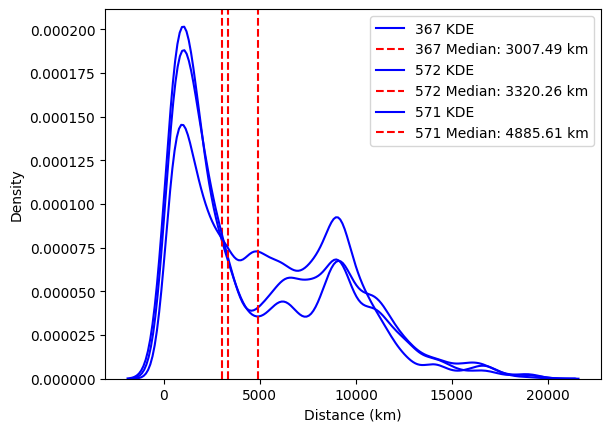

In [19]:
# This is to see the distance travelled for each item to select a minimum distance for air-freight

food_items = [367, 572, 571]  # Asparagus, avocado, mango

# Loop through each food item
for food in food_items:
    # Filter DataFrame for the specific food item
    data = full_trade_mx2[full_trade_mx2['Item_Code'] == food]['distance_in_km']

    # Calculate median distance for the food item
    median_distance = data.median()

    # Create KDE plot
    ax = sns.kdeplot(
        data=data,
        common_norm=False,  # Normalizes each category independently
        color='blue',       # Set color for the KDE plot
        label=f'{food} KDE'
    )

    # Plot vertical line at median
    plt.axvline(median_distance, color='red', linestyle='--', label=f'{food} Median: {median_distance:.2f} km')

# Set labels and legend
plt.xlabel('Distance (km)')
plt.ylabel('Density')
plt.legend()

# Show plot
plt.show()

In [20]:
result_items.head()

,Item_Code,Item,conservation,diet,food_type
8,1021,Cheese from milk of goats; fresh or processed,Chilled,vegetarian,dairy/eggs
269,367,Asparagus,Fresh,vegan,fruit/vegetable
271,372,Lettuce and chicory,Fresh,vegan,fruit/vegetable
279,393,Cauliflowers and broccoli,Fresh,vegan,fruit/vegetable
289,414,Other beans; green,Fresh,vegan,legume


In [21]:
# Imput air only if distance is more than xxxxx km and only for selected fresh fruits, vegetables, dairy products

condition3 = (                                                              #depends on DIFFERENT CONTINENT
    (full_trade_mx2['same_continent'] == 0) &
    (full_trade_mx2['Item Code'].isin(result_items['Item_Code'].tolist())) &
    (full_trade_mx2['conservation'].isin(['Fresh', 'Chilled']))
)

condition4 = (                                                              #depends on DISTANCE
    (full_trade_mx2['distance_in_km'] > 5000) &
    (full_trade_mx2['Item Code'].isin(result_items['Item_Code'].tolist())) &
    (full_trade_mx2['conservation'].isin(['Fresh', 'Chilled']))
)

full_trade_mx2['air'] = np.where(condition3 | condition4, 1, 0)

print(full_trade_mx2['air'].value_counts(normalize=True, dropna=False))

air
0    0.966035
1    0.033965
Name: proportion, dtype: float64


In [22]:
full_trade_mx2['transportation_method'] = np.where(full_trade_mx2['air'] == 1, 'air', full_trade_mx2['transportation_method'])

In [23]:
full_trade_mx2['transportation_method'].value_counts(normalize=True, dropna=False)

transportation_method
water    0.565754
land     0.400281
air      0.033965
Name: proportion, dtype: float64

In [24]:
full_trade_mx2[full_trade_mx2['Item_Code'] == 367]['air'].value_counts(normalize=True) # Asparagus

air
0    0.520847
1    0.479153
Name: proportion, dtype: float64

In [25]:
full_trade_mx2[full_trade_mx2['Item_Code'] == 367]['transportation_method'].value_counts(normalize=True) # Asparagus

transportation_method
air      0.479153
land     0.438963
water    0.081884
Name: proportion, dtype: float64

In [26]:
full_trade_mx2['food_miles'] = full_trade_mx2['Value_tons'] * full_trade_mx2['distance_in_km']

In [27]:
full_trade_mx2.groupby('transportation_method')['food_miles'].sum()

transportation_method
air      5.095785e+12
land     1.855412e+13
water    1.373227e+14
Name: food_miles, dtype: float64

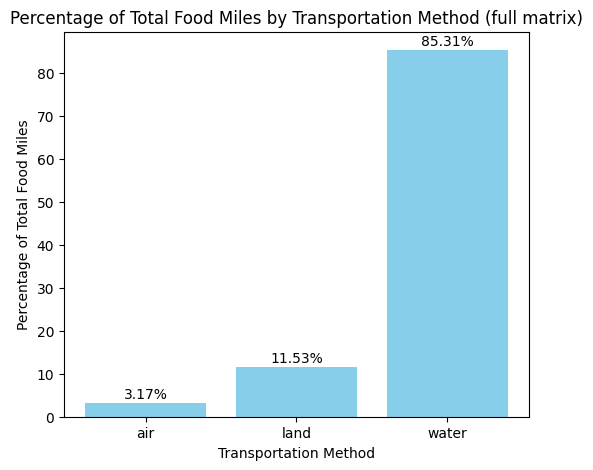

In [28]:
# Group the DataFrame by 'transportation_method' and sum the 'food_miles' for each method
transportation_method_sum = full_trade_mx2.groupby('transportation_method')['food_miles'].sum()

# Calculate the total sum of 'food_miles'
total_food_miles = transportation_method_sum.sum()

# Calculate the percentage of total for each transportation method
percentage_of_total = (transportation_method_sum / total_food_miles) * 100

# Create the bar plot
plt.figure(figsize=(6, 5))
bars = plt.bar(percentage_of_total.index, percentage_of_total.values, color='skyblue')

# Add labels above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.2f}%', ha='center', va='bottom')

# Set plot title and labels
plt.title('Percentage of Total Food Miles by Transportation Method (full matrix)')
plt.xlabel('Transportation Method')
plt.ylabel('Percentage of Total Food Miles')

# Display the plot
plt.show()

## Comparison with conditions 1 and 2 to impute air

In [29]:
# Group the DataFrames by 'transportation_method' and sum the 'food_miles' for each method
"""transportation_method_sum1 = full_trade_mx1.groupby('transportation_method')['food_miles'].sum()
transportation_method_sum2 = full_trade_mx2.groupby('transportation_method')['food_miles'].sum()

# Calculate the total sum of 'food_miles' for each DataFrame
total_food_miles1 = transportation_method_sum1.sum()
total_food_miles2 = transportation_method_sum2.sum()

# Calculate the percentage of total for each transportation method
percentage_of_total1 = (transportation_method_sum1 / total_food_miles1) * 100
percentage_of_total2 = (transportation_method_sum2 / total_food_miles2) * 100

# Create a combined DataFrame
combined_df = pd.DataFrame({
    'full_trade_mx1': percentage_of_total1,
    'full_trade_mx2': percentage_of_total2
}).reset_index()

# Create the grouped bar plot
plt.figure(figsize=(10, 6))
bar_width = 0.35
bar_positions1 = range(len(combined_df))
bar_positions2 = [p + bar_width for p in bar_positions1]

bars1 = plt.bar(bar_positions1, combined_df['full_trade_mx1'], width=bar_width, label='full_trade_mx1', color='skyblue')
bars2 = plt.bar(bar_positions2, combined_df['full_trade_mx2'], width=bar_width, label='full_trade_mx2', color='lightgreen')

# Add labels above the bars
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.2f}%', ha='center', va='bottom')

# Set plot title and labels
plt.title('Percentage of Total Food Miles by Transportation Method')
plt.xlabel('Transportation Method')
plt.ylabel('Percentage of Total Food Miles')
plt.xticks([p + bar_width / 2 for p in bar_positions1], combined_df['transportation_method'])

# Add legend
plt.legend()

# Display the plot
plt.show()
"""

"transportation_method_sum1 = full_trade_mx1.groupby('transportation_method')['food_miles'].sum()\ntransportation_method_sum2 = full_trade_mx2.groupby('transportation_method')['food_miles'].sum()\n\n# Calculate the total sum of 'food_miles' for each DataFrame\ntotal_food_miles1 = transportation_method_sum1.sum()\ntotal_food_miles2 = transportation_method_sum2.sum()\n\n# Calculate the percentage of total for each transportation method\npercentage_of_total1 = (transportation_method_sum1 / total_food_miles1) * 100\npercentage_of_total2 = (transportation_method_sum2 / total_food_miles2) * 100\n\n# Create a combined DataFrame\ncombined_df = pd.DataFrame({\n    'full_trade_mx1': percentage_of_total1,\n    'full_trade_mx2': percentage_of_total2\n}).reset_index()\n\n# Create the grouped bar plot\nplt.figure(figsize=(10, 6))\nbar_width = 0.35\nbar_positions1 = range(len(combined_df))\nbar_positions2 = [p + bar_width for p in bar_positions1]\n\nbars1 = plt.bar(bar_positions1, combined_df['full_t

## Compare food miles per transportation method for each food item (asparagus, avocado, mango)

In [30]:
# Define the list of food items to compare
food_items = [367, 572, 571]  # Asparagus, avocado, mango

# Filter the DataFrames to include only the specified food items
#filtered_mx1 = full_trade_mx1[full_trade_mx1['Item_Code'].isin(food_items)]
filtered_mx2 = full_trade_mx2[full_trade_mx2['Item_Code'].isin(food_items)]

# Group the filtered DataFrames by 'Item_Code' and sum the 'food_miles'
#food_items_sum1 = filtered_mx1.groupby(['transportation_method', 'Item_Code'])['food_miles'].sum().to_frame().reset_index()
food_items_sum2 = filtered_mx2.groupby(['transportation_method', 'Item_Code'])['food_miles'].sum().to_frame().reset_index()

In [31]:
#full_trade_mx1[full_trade_mx1['Item_Code'].isin(food_items)]['transportation_method'].value_counts(normalize=True, dropna=False)

In [32]:
full_trade_mx2[full_trade_mx2['Item_Code'].isin(food_items)]['transportation_method'].value_counts(normalize=True, dropna=False)

transportation_method
air      0.568337
land     0.357700
water    0.073964
Name: proportion, dtype: float64

For these items it is exactly the same. I must change on other items.

# Which items are shipped by air with conditions 1 and 2?

In [33]:
#items_condition12 = set(full_trade_mx1.query('air == 1')['Item_Code'])

In [34]:
#items[items['Item_Code'].isin(items_condition12)].sample(10)

In [35]:
items_condition34 = set(full_trade_mx2.query('air == 1')['Item_Code'])

In [36]:
items[items['Item_Code'].isin(items_condition34)].sample(10)

,Item_Code,Item,conservation,diet,food_type
293,426,Carrots and turnips,Fresh,vegan,fruit/vegetable
322,490,Oranges,Fresh,vegan,fruit/vegetable
381,580,Juice of pineapples; concentrated,Chilled,vegan,fruit/vegetable
374,571,Mangoes; guavas and mangosteens,Fresh,vegan,fruit/vegetable
359,554,Cranberries,Fresh,vegan,fruit/vegetable
382,583,Juice of mango,Chilled,vegan,fruit/vegetable
530,901,Cheese from whole cow milk,Chilled,vegetarian,dairy
327,497,Lemons and limes,Fresh,vegan,fruit/vegetable
271,372,Lettuce and chicory,Fresh,vegan,fruit/vegetable
375,572,Avocados,Fresh,vegan,fruit/vegetable


In [37]:
#len(items_condition12.difference(items_condition34))

# Calculate carbon footprint based on transportation method and food miles

In [38]:
full_trade_mx3 = full_trade_mx2.copy()

In [39]:
full_trade_mx3.drop('air', axis=1, inplace=True)

In [40]:
def calculate_carbon_footprint(row):
    """Calculates carbon footprint for a row based on food miles, transport type and conservation.

    Args:
        row: A pandas Series representing a single row of the dataframe.

    Returns:
        The calculated carbon footprint.
    """
    transport_type = row['transportation_method']
    conservation_type = row['conservation']
    food_miles = row['food_miles']

    # Constants for emission factors (CO2 equivalent per mile)
    transport_factors = {
        'land': {'Ambient': 0.2, 'Chilled': 0.53, 'Fresh': 0.53},  # average for chill fresh from source table (ourworld in data)
        'water': {'Ambient': 0.01, 'Chilled': 0.02, 'Fresh': 0.02},
        'air': {'Ambient': 1.13, 'Chilled': 1.13, 'Fresh': 1.13}
    }

    # Get emission factor based on transport and conservation
    emission_factor = transport_factors.get(transport_type, {}).get(conservation_type, 0.01)  # Default to 0.01 if not found

    return food_miles * emission_factor

In [41]:
full_trade_mx3['kgCO2eq_tkm'] = full_trade_mx3.apply(calculate_carbon_footprint, axis=1)

In [42]:
full_trade_mx3.head()

,Reporter Country Code,Partner Country Code,Item Code,Year,Value_tons,Flag,distance_in_km,same_continent,share_border,any_island_or_missing,transportation_method,Item_Code,conservation,food_type,food_miles,kgCO2eq_tkm
0,4,2,231,2005,3.00,A,5855.362822,0,0.0,0,water,231,Ambient,nuts,1.756609e+04,175.660885
1,3,3,56,2005,52.00,A,108.698297,1,1.0,0,land,56,Ambient,grain,5.652311e+03,1130.462293
2,7,2,176,2022,25.06,A,7596.963990,0,0.0,0,water,176,Ambient,legume,1.903799e+05,1903.799176
3,4,2,711,1996,171.00,A,5855.362822,0,0.0,0,water,711,Ambient,other,1.001267e+06,10012.670425
4,4,2,711,1997,160.00,A,5855.362822,0,0.0,0,water,711,Ambient,other,9.368581e+05,9368.580515


In [43]:
cols_to_drop = ["Item_Code","conservation","food_type"]
full_trade_mx3.drop(cols_to_drop, axis=1, inplace=True)

In [44]:
full_trade_mx3.to_parquet(r"..\data\FAOSTAT\clean_data\food_trading\trade_matrix_carbon_footprint_v4.parquet", index=False)